# 1. Import Packages

PIL Image로는 X server가 없다며 이미지를 안보여준다.
IPython.display의 Image를 통해 이미지 확인

In [1]:
from transformers import(
    VisionEncoderDecoderModel, 
    ViTFeatureExtractor, 
    AutoModelForCausalLM,
    AutoTokenizer,
    PreTrainedTokenizerFast
)
import torch
import numpy as np
from PIL import Image
import pandas as pd
import json
from sklearn.model_selection import train_test_split
from IPython.display import Image as Image2See

# 2. Captioning Model 불러오기


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
#device = "cpu"

In [3]:
# load captioning model
encoder_model_name_or_path = "ddobokki/vision-encoder-decoder-vit-gpt2-coco-ko"
caption_tokenizer = PreTrainedTokenizerFast.from_pretrained(encoder_model_name_or_path)
feature_extractor = ViTFeatureExtractor.from_pretrained(encoder_model_name_or_path)
caption_model = VisionEncoderDecoderModel.from_pretrained(encoder_model_name_or_path)

# 3. Poem Model 불러오기
청계산 셰르파 org에서 불러온다. transformers-cli login을 실행해 권한을 받아오는 것이 필요함.

In [ ]:
#!transformers-cli login

In [ ]:
#path = "goodjw/gpt-trinity-poem"

In [4]:
# load poem model
#path = "CheonggyeMountain-Sherpa/kogpt-trinity-poem"
#path = "/opt/ml/final-project-level3-nlp-08/10epoch"
#path = "/opt/ml/final-project-level3-nlp-08/20epoch"
path = "/opt/ml/final-project-level3-nlp-08/outputs"
poem_model = AutoModelForCausalLM.from_pretrained(path, use_auth_token=True) 
poem_tokenizer = AutoTokenizer.from_pretrained(path, use_auth_token=True)

# 4. Image2Poem Module을 통해 하나로 연결
forward로 위 두 모델을 연결한다.

MSCOCO 이미지 데이터셋의 img path를 모델에 넣어주면 해당 이미지를 로드하고

캡션 모델을 통해 캡션을 뽑아낸 후,

그 캡션으로 시를 생성한다.

image_path[str] -> poem[str]

In [152]:
class Image2Poem(torch.nn.Module):
    def __init__(self, feature_extractor, caption_model, caption_tokenizer, poem_model, poem_tokenizer):
        super(Image2Poem, self).__init__()
        self.feature_extractor = feature_extractor
        self.caption_model = caption_model
        self.caption_tokenizer = caption_tokenizer
        self.poem_model = poem_model
        self.poem_tokenizer = poem_tokenizer
    
    def forward(self, filepath_for_image):
        device = "cuda" if torch.cuda.is_available() else "cpu"
        image = Image.open(filepath_for_image).convert("RGB")
        image_tensor = np.array(image)
        pixel_values = self.feature_extractor(image_tensor, return_tensors="pt").pixel_values.to(device)
        generated_ids = self.caption_model.generate(pixel_values, num_beams=5)
        #generated_ids = self.caption_model.generate(pixel_values, do_sample=True, top_p=0.7)
        caption = self.caption_tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
        prompt = f"@{caption}@\n"
        #prompt = "@어린 소녀와 냉장고@"
        prompt = self.poem_tokenizer.encode(prompt, return_tensors="pt").to(device)
        #prompt = self.poem_tokenizer.encode(caption, return_tensors="pt").to(device)
        poem_output = self.poem_model.generate(
            prompt,
            max_length=70,
            repetition_penalty=2.0,
            pad_token_id=self.poem_tokenizer.pad_token_id,
            eos_token_id=self.poem_tokenizer.eos_token_id,
            bos_token_id=self.poem_tokenizer.bos_token_id,
            do_sample=True,
            bad_words_ids=[[0], [2], [3], [4], [5], [6], [7], [8]],
            top_k=30,
            top_p=0.95
        )
        poem = self.poem_tokenizer.decode(poem_output[0])
        return poem

In [153]:
prototype_model = Image2Poem(feature_extractor, caption_model, caption_tokenizer, poem_model, poem_tokenizer).to(device)
prototype_model.eval()

Image2Poem(
  (caption_model): VisionEncoderDecoderModel(
    (encoder): ViTModel(
      (embeddings): ViTEmbeddings(
        (patch_embeddings): PatchEmbeddings(
          (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
        )
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (encoder): ViTEncoder(
        (layer): ModuleList(
          (0): ViTLayer(
            (attention): ViTAttention(
              (attention): ViTSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
              (output): ViTSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
            )
            (int

# 5. 데이터셋 불러오기
**주의할 점: 환경에 따라 아래 두 path 변수를 변경해준다**

data_path는 train2014, valid2014가 있는 경로

In [7]:
coco_json_path = '/opt/ml/final-project-level3-nlp-08/MSCOCO_train_val_Korean.json'
data_path = '/opt/ml/final-project-level3-nlp-08/'

In [8]:
with open(coco_json_path, 'r') as f:
    coco = json.load(f)
    
img_path = []
total_caption_lst = []
for i in range(len(coco)):
    # 캡션 5개 미만이면 추가하지 않음
    if len(coco[i]['caption_ko']) < 5:
        continue
    # img path 추가
    img_path.append(data_path + coco[i]['file_path'])

    # img path와 매칭되는 caption 5개 추가
    caption_lst = []
    for j in range(5):
        caption_lst.append(coco[i]['caption_ko'][j])
    total_caption_lst.append(caption_lst)

In [9]:
coco_df = pd.DataFrame(data={
    'labels': total_caption_lst,
    'img_paths': img_path
})

In [10]:
coco_data = coco_df
train_df, val_df = train_test_split(coco_data, test_size=0.2, random_state=42)
val_df = val_df.reset_index()
img, label = val_df['img_paths'], val_df['labels']

In [ ]:
img[0]

'/opt/ml/final-project-level3-nlp-08/train2014/COCO_train2014_000000381766.jpg'

In [11]:
impath = '/opt/ml/final-project-level3-nlp-08/train2014/'
#img_name = "COCO_train2014_000000123837"
img_name = "COCO_train2014_000000123831"
filetype = ".jpg"
filename = impath + img_name + filetype

In [76]:
#index = 66
#index = 270
#index = 253
#index = 1230
#index = 2743
#index = 7420
index = 2510

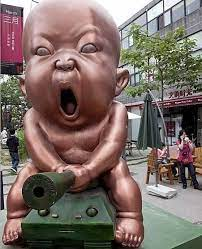

@동상 위에 앉아 있는 곰 동상@
오늘의 내 마음은 두터운 고드름처럼 얼어서 바람불면 휘청이거니
어느새 그대는 나의 우러르고 
나는 당신 앞에 서있는 듯 비애와 같은 눈물을 흘리누나.
지금 이렇게 추운데 당신은 무슨 생각을 하면서 기다리고 있나요
이 얼어


In [165]:
display(Image2See("/opt/ml/testimage/dapo.jpg"))
print(prototype_model("/opt/ml/testimage/dapo.jpg"))

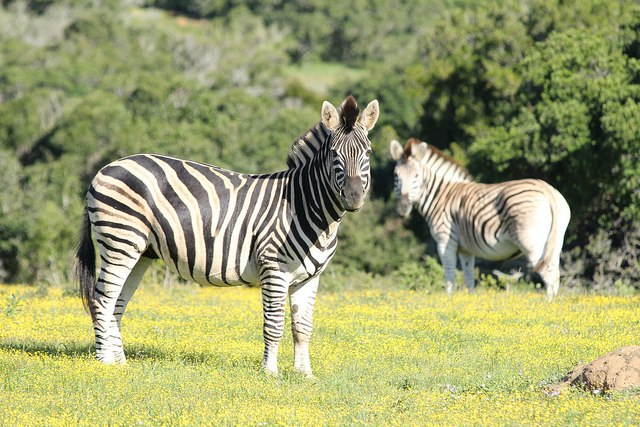

@얼룩말 두마리가 초원에 서 있다.@
우리는 어느덧 동화가 되어있다.
비온 뒤 안개가 엷게 깔린 날,
조그마한 언덕 길을 함께 거닐며.
우리들은 어느새 장화처럼 말끔하게 면도가 되었다.
한때는 우리가 했던 그 맹세들을 우리는 아직 하고 있다.
아, 얼룩말이


In [39]:
display(Image2See(img[index]))
print(prototype_model(img[index]))

In [82]:
prompt = "@테디 베어 옆 벤치에 앉아 있는 여자@\n"
prompt = poem_tokenizer.encode(prompt, return_tensors="pt").to(device)
poem_output = poem_model.generate(
            prompt,
            max_length=70,
            repetition_penalty=2.0,
            pad_token_id=poem_tokenizer.pad_token_id,
            eos_token_id=poem_tokenizer.eos_token_id,
            bos_token_id=poem_tokenizer.bos_token_id,
            do_sample=True,
            top_k=30,
            top_p=0.95
        )
poem = poem_tokenizer.decode(poem_output[0])
print(poem)

@테디 베어 옆 벤치에 앉아 있는 여자@
우유빛깔의 하얀 털과
새빨간 입술을 가지고 있는
네 개의 눈은
세상에 하나 뿐인
곰이 가진 유일한 웃음인듯 하다.
네가 웃고 있을 때
나는 한 마리의 곰처럼 느껴졌다.
눈앞에 보이는 두 쌍으로
파닥 파다리는 네 발굽이



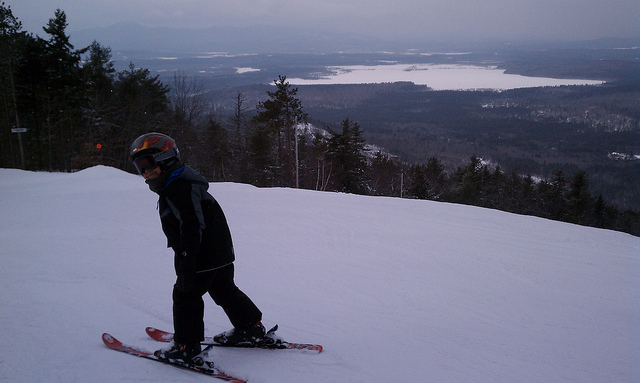

@스키를 타고 눈 덮인 비탈을 내려오는 남자.@
눈을 굴리며 내려온다,
내리는 눈은 마치 폭포처럼 쏟아지고 
쌓이는 눈의 결들은 파문을 친다.
아득한 수평선 위로 나의 꿈도 펼쳐진다.
보라 오늘 밤은 내가 또 하나의 눈을 뒤집어 쓴 채 밤을 새야 하는구나.
그러나


In [28]:
display(Image2See(img[index]))
print(prototype_model(img[index]))

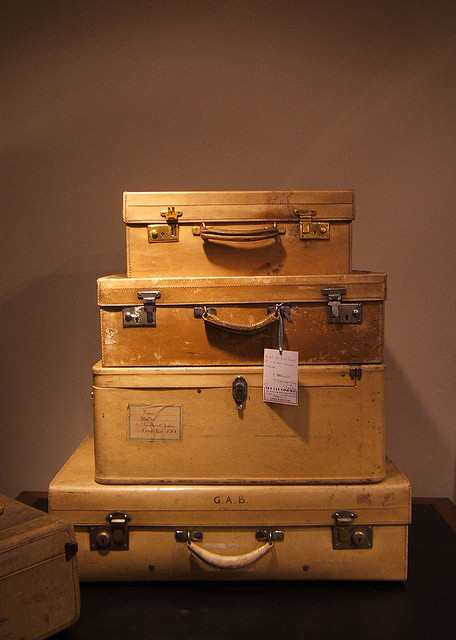

@여행 가방들이 차곡차곡 쌓여 있다.@
자유를 찾아 먼 길 떠나는 나에게 마을 사람들은 수삼 세 덩이 금반지를 주었다. 
미국을 향한 자랑스러운 조국과 민족을, 그리고 가난 속에서도 꿈을 잃지 않는 우리 젊은이들을 위하여,
그리고 모든 계집애들의 참다운 순


In [20]:
display(Image2See(filename=filename))
for i in range(1):
    #print(f"trial{i}")
    print(prototype_model(filename))
    #print()

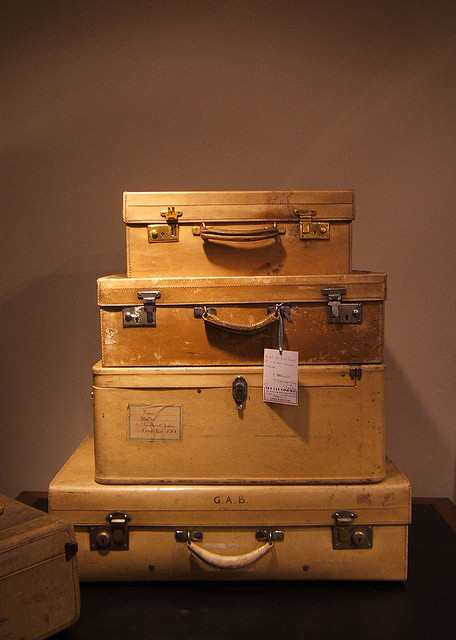

여행 가방들이 차곡차곡 쌓여 있다
가방은 점점 무거워지고 나는 자꾸만 흘러내린다
무거운 짐들을 하나씩 들고 앞으로 나아갈 때 우리는 조금 더 젊어진다
이국의 해변에서 파도가 부서질 때, 그때마다 나의 몸도 조금씩 자란다
그리고 내가 자라면서 누군가의 삶에 섞여 들어간다



In [30]:
whatitdid = "여행 가방들이 차곡차곡 쌓여 있다. 가방은 점점 무거워지고 나는 자꾸만 흘러내린다. 무거운 짐들을 하나씩 들고 앞으로 나아갈 때 우리는 조금 더 젊어진다. 이국의 해변에서 파도가 부서질 때, 그때마다 나의 몸도 조금씩 자란다. 그리고 내가 자라면서 누군가의 삶에 섞여 들어간다."
display(Image2See(filename=filename))
for s in whatitdid.split('.'):
    print(s.strip())